In [1]:
# Boilerplate at top of file
%load_ext autoreload
%load_ext rmagic
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from ggplot import *

import json


from IPython.display import Image



from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
import sklearn.cross_validation as cross_validation

/usr/local/lib/python2.7/site-packages/IPython/extensions/rmagic.py:11: UserWarning: The rmagic extension in IPython has moved to `rpy2.ipython`, please see `rpy2` documentation.
  warnings.warn("The rmagic extension in IPython has moved to "


In [2]:
print plt.style.available

[u'dark_background', u'bmh', u'grayscale', u'ggplot', u'fivethirtyeight']


In [3]:
df_left = pd.read_csv('data/merged/look_left.csv')
df_right = pd.read_csv('data/merged/look_right.csv')

df_straight = pd.read_csv('data/merged/look_straight.csv')
### hack
# Assume class 0 is always when face is forward for any data set

# look-right events are class 3 and 4
df_right['class'] = df_right['class'].apply(lambda x: x + 2 if x > 0 else 0)
df = pd.concat([df_left, df_right, df_straight])
n = len(df)



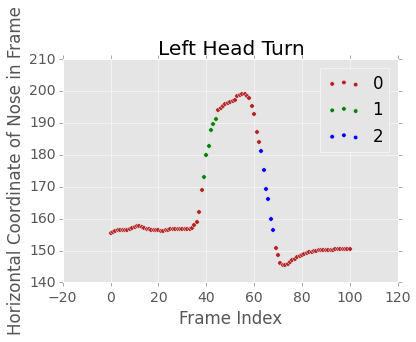

In [33]:
color_map = ['firebrick', 'green', 'blue', 'darkgoldenrod', 'black']
def scatter_by_class(df, class_col):

    for g in set(df[class_col].tolist()):
        plt.scatter(df[df[class_col] == g].index, 
                    df[df[class_col]==g].noseX, c=color_map[g],  label=g)
    plt.legend()
df_mini =df_left.loc[0:100]
plt.title('Left Head Turn')
scatter_by_class(df_mini, 'class')
plt.xlabel('Frame Index')
plt.ylabel('Horizontal Coordinate of Nose in Frame')
# plt.scatter(df_mini.index, df_mini.noseX, c=df_mini['class'])

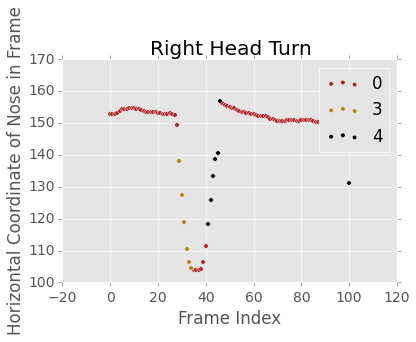

In [34]:
color_map = ['firebrick', 'green', 'blue', 'darkgoldenrod', 'black']
def scatter_by_class(df, class_col):

    for g in set(df[class_col].tolist()):
        plt.scatter(df[df[class_col] == g].index, 
                    df[df[class_col]==g].noseX, c=color_map[g],  label=g)
    plt.legend()
df_mini =df_right.loc[0:100]
plt.title('Right Head Turn')
scatter_by_class(df_mini, 'class')
plt.xlabel('Frame Index')
plt.ylabel('Horizontal Coordinate of Nose in Frame')
# plt.scatter(df_mini.index, df_mini.noseX, c=df_mini['class'])

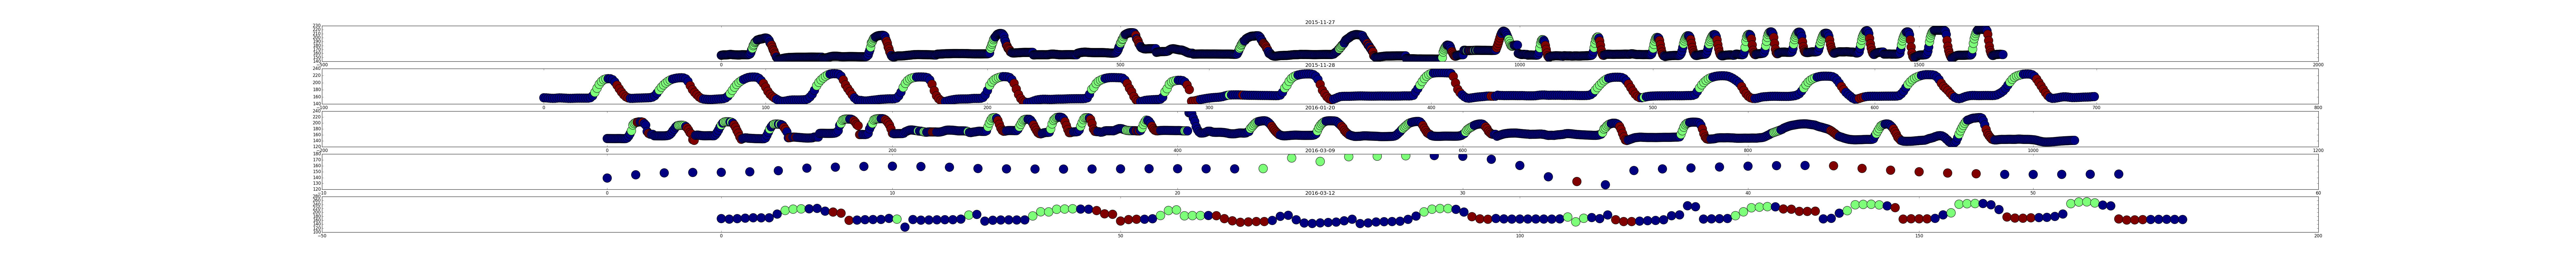

In [5]:
Image(filename='data/merged/look_left-plots.png')


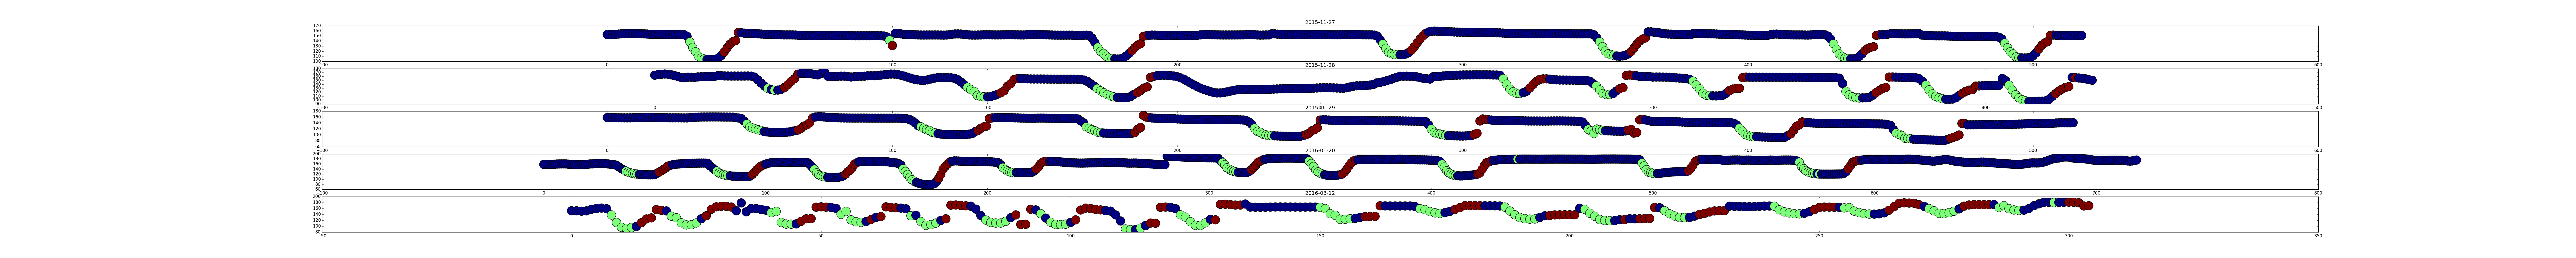

In [6]:
Image(filename='data/merged/look_right-plots.png')

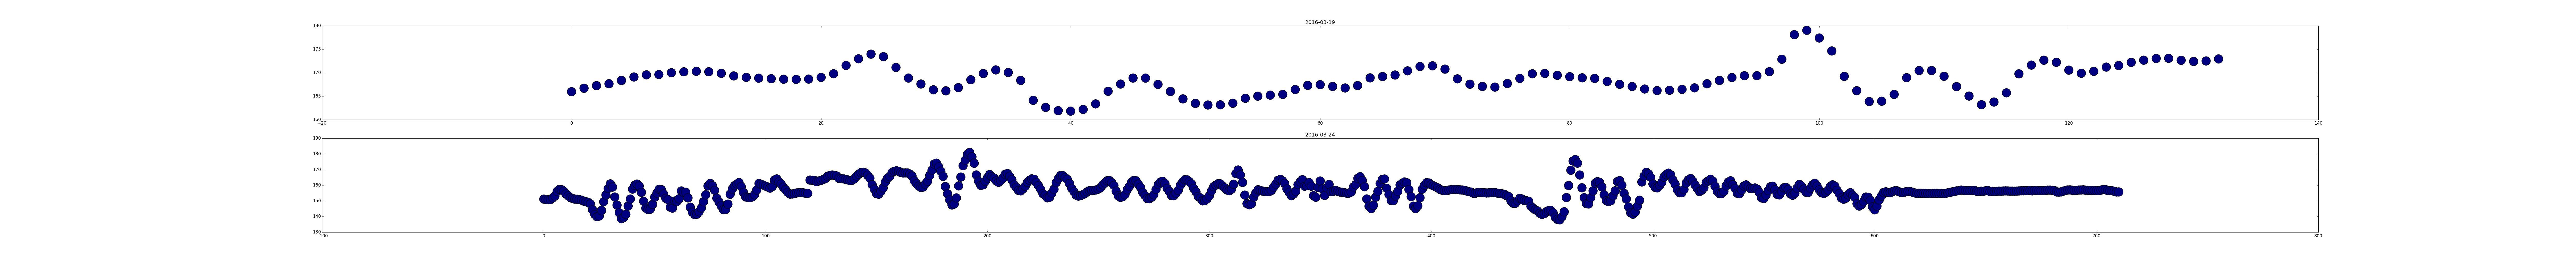

In [7]:
Image(filename='data/merged/look_straight-plots.png')


In [8]:
config = json.loads(open('config.json','r').read())
active_features = config['active_features']

0.975246091488


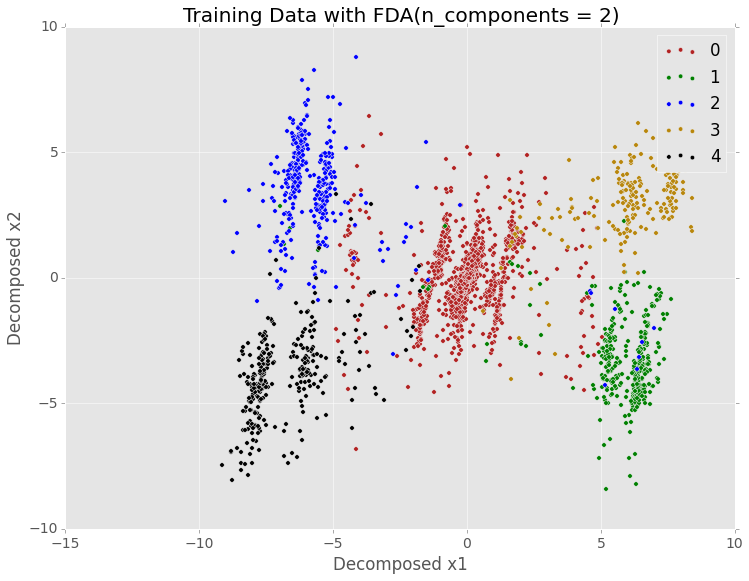

In [30]:
# color_map = ['r', 1='g', 2='b', 3='orange',4='bl')
color_map = ['firebrick', 'green', 'blue', 'darkgoldenrod', 'black']
def scatter_by_class(X, df, class_col):

    for g in set(df[class_col].tolist()):
        plt.scatter(X[np.where(df[class_col] == g),0], X[np.where(df[class_col] == g),1], c=color_map[g],  label=g)
    plt.legend()
plt.rcParams.update({'font.size': 14})
# pca = PCA(n_components=2)
plt.figure(figsize=(12,9))
# plt.subplot(1,2,1)
# X = pca.fit_transform(df[config['active_features']])
# # plt.scatter(X[:,0],X[:,1], c=df['class'])
# scatter_by_class(X, df, 'class')
# plt.title('Training Data with PCA(n_components = 2)')
# plt.xlabel('Decomposed x1')
# plt.ylabel('Decomposed x2')


# from sklearn.lda import LDA
# plt.subplot(1,2,2)
# lda = LDA(n_components=2)
# X_lda = lda.fit_transform(df[active_features], df['class'])



# scatter_by_class(X, df, 'class')
# plt.scatter(X_lda[df[:,0],X_lda[:,1], c=df['class'])
scatter_by_class(X_lda, df, 'class')
plt.title("Training Data with FDA(n_components = 2)")
plt.xlabel('Decomposed x1')
plt.ylabel('Decomposed x2')

y_pred = lda.predict(df[active_features])
print sum(y_pred == df['class']) / float(len(df))

In [10]:
class_col = 'class'
X[np.where(df[class_col] == 0),1]

array([[ 0.37916742,  0.25456995, -0.45739861, ..., -0.20231291,
        -0.14988855,  0.01547443]])

In [11]:
np.where(df[class_col] == 0)

(array([   0,    1,    2, ..., 6905, 6906, 6907]),)

In [12]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder


def compute_metrics(X_test, Y_test, Y_pred, label):
    i = label

    id_rated_t = X_test.index[Y_pred == i]
    id_is_t = X_test.index[Y_test == i]
    n = len(X_test)
    truths = set(id_is_t)
    positives = set(id_rated_t)
    tp = len(truths.intersection(positives))
    fp = len(positives.difference(truths.intersection(positives)))
    fn = len(truths.difference(truths.intersection(positives)))
    tn = n - tp - fp - fn


    precision = tp / float(max([1,fp + tp]))
    recall = tp / float(max([1,tp + fn]))
    accuracy = (tp + tn) / float(n)
    return (precision, recall, accuracy)

def train_split_classify(df, active_features, y_feature, clf, k = 10, verbose=False,
                        class_label_append = ''):
    X = df[active_features]
    Y = LabelEncoder().fit_transform(df[y_feature])
    classes = set(Y)
    accuracies = [[]]*len(classes)
    recalls = [[]]*len(classes)
    precisions = [[]]*len(classes)
    print '\n======\n'
    print 'Cross validating for', clf.__class__

    for i in xrange(k):
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=0.3, random_state=42
        )
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)

        for i in classes:

            precision, recall, accuracy = compute_metrics(X_test, Y_test, Y_pred, i)
            accuracies[i].append(accuracy)
            recalls[i].append(recall)
            precisions[i].append(precision)
            if verbose==True:
                print "Class", i 
                print 'precision', precision
                print 'recall', recall
                print 'accuracy', accuracy
                print '\n======'
    
    metrics = []
    for i in classes:
        for j in xrange(k):
            metrics.append(dict(
                run=j,
                label=i,
                precision=precisions[i][j],
                recall=recalls[i][j],
                accuracy=accuracies[i][j],
                classifier=str(clf.__class__) + class_label_append,
                ))
    return metrics
#     print 'Confusion Matrix:', sum(cof_mat)
#     print 'Accuracy:', np.mean(accuracies)
#     print 'Recall:', np.mean(recalls)
#     print 'Precision:', np.mean(precisions)

In [13]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


res = []
# svm = SVC(decision_function_shape='ovo')
# res += train_split_classify(df, config['active_features'], 'class',svm)

rf = RandomForestClassifier()
res += train_split_classify(df, config['active_features'], 'class',rf)

gbc = GradientBoostingClassifier()
res += train_split_classify(df, config['active_features'], 'class',gbc)

knn = KNeighborsClassifier(n_neighbors=10)
res += train_split_classify(df, config['active_features'], 'class',knn,  class_label_append='k=10')

lda = LDA()
res += train_split_classify(df, config['active_features'], 'class',lda)


knn2 = KNeighborsClassifier(n_neighbors=5)
res += train_split_classify(df, config['active_features'], 'class',knn2, class_label_append='k=5')


# combine results
df_res = pd.DataFrame(res)



Cross validating for <class 'sklearn.ensemble.forest.RandomForestClassifier'>


Cross validating for <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>


Cross validating for <class 'sklearn.neighbors.classification.KNeighborsClassifier'>


Cross validating for <class 'sklearn.lda.LDA'>


Cross validating for <class 'sklearn.neighbors.classification.KNeighborsClassifier'>


In [14]:
df_res.groupby('classifier').mean()[['accuracy', 'precision','recall']]

accuracy  precision  \
classifier                                                                
<class 'sklearn.ensemble.forest.RandomForestCla...  0.995369   0.977800   
<class 'sklearn.ensemble.gradient_boosting.Grad...  0.994211   0.971671   
<class 'sklearn.lda.LDA'>                           0.991413   0.948974   
<class 'sklearn.neighbors.classification.KNeigh...  0.994018   0.973575   
<class 'sklearn.neighbors.classification.KNeigh...  0.994018   0.964240   

                                                      recall  
classifier                                                    
<class 'sklearn.ensemble.forest.RandomForestCla...  0.952474  
<class 'sklearn.ensemble.gradient_boosting.Grad...  0.946145  
<class 'sklearn.lda.LDA'>                           0.936362  
<class 'sklearn.neighbors.classification.KNeigh...  0.934007  
<class 'sklearn.neighbors.classification.KNeigh...  0.937343

In [15]:
df_res.groupby(['classifier', 'label']).median()

accuracy  precision  \
classifier                                         label                        
<class 'sklearn.ensemble.forest.RandomForestCla... 0      0.995658   0.987409   
                                                   1      0.995658   0.987409   
                                                   2      0.995658   0.987409   
                                                   3      0.995658   0.987409   
                                                   4      0.995658   0.987409   
<class 'sklearn.ensemble.gradient_boosting.Grad... 0      0.994694   0.982906   
                                                   1      0.994694   0.982906   
                                                   2      0.994694   0.982906   
                                                   3      0.994694   0.982906   
                                                   4      0.994694   0.982906   
<class 'sklearn.lda.LDA'>                          0      0.993247   0.940476   
                                                   1      0.993247   0.940476   
                                                   2      0.993247   0.940476   
                                                   3      0.993247   0.940476   
                                                   4      0.993247   0.940476   
<class 'sklearn.neighbors.classification.KNeigh... 0      0.994694   0.974790   
                                                   1      0.994694   0.974790   
                                                   2      0.994694   0.974790   
                                                   3      0.994694   0.974790   
                                                   4      0.994694   0.974790   
<class 'sklearn.neighbors.classification.KNeigh... 0      0.995176   0.958333   
                                                   1      0.995176   0.958333   
                                                   2      0.995176   0.958333   
                                                   3      0.995176   0.958333   
                                                   4      0.995176   0.958333   

                                                            recall  run  
classifier                                         label                 
<class 'sklearn.ensemble.forest.RandomForestCla... 0      0.959821  4.5  
                                                   1      0.959821  4.5  
                                                   2      0.959821  4.5  
                                                   3      0.959821  4.5  
                                                   4      0.959821  4.5  
<class 'sklearn.ensemble.gradient_boosting.Grad... 0      0.941964  4.5  
                                                   1      0.941964  4.5  
                                                   2      0.941964  4.5  
                                                   3      0.941964  4.5  
                                                   4      0.941964  4.5  
<class 'sklearn.lda.LDA'>                          0      0.940476  4.5  
                                                   1      0.940476  4.5  
                                                   2      0.940476  4.5  
                                                   3      0.940476  4.5  
                                                   4      0.940476  4.5  
<class 'sklearn.neighbors.classification.KNeigh... 0      0.937500  4.5  
                                                   1      0.937500  4.5  
                                                   2      0.937500  4.5  
                                                   3      0.937500  4.5  
                                                   4      0.937500  4.5  
<class 'sklearn.neighbors.classification.KNeigh... 0      0.928571  4.5  
                                                   1      0.928571  4.5  
                                                   2      0.928571  4.5  
                    

# Testing on Pure Test Data

In [16]:
df_left_test = pd.read_csv('data/merged/look_left_test.csv')
df_right_test = pd.read_csv('data/merged/look_right_test.csv')

df_straight_test = pd.read_csv('data/merged/look_straight_test.csv')
### hack
# Assume class 0 is always when face is forward for any data set

# look-right events are class 3 and 4
df_right_test['class'] = df_right_test['class'].apply(lambda x: x + 2 if x > 0 else 0)
df_test = pd.concat([df_left_test, df_right_test, df_straight_test])


In [17]:
active_features = config['active_features']

In [18]:
def compute_test_data(df, df_test, clf):
    Y_test = df_test['class']
    classes = set(Y_test)
    X_test = df_test[active_features]
    clf.fit(df[active_features], df['class'])
    Y_pred = clf.predict(X_test)
    print 'PREDICTING TEST RESULTS FOR ', clf.__class__
    for i in classes:
        print i
        print compute_metrics(X_test, Y_test, Y_pred,i)

In [19]:
active_features


[u'noseY_1_steps_2',
 u'faceRight_6_steps_2',
 u'faceRight_6_steps_0',
 u'faceRight_6_steps_1',
 u'faceTop_1_steps_0',
 u'faceTop_1_steps_1',
 u'faceTop_1_steps_2',
 u'noseY_6_steps_2',
 u'isFrontFace_6_steps_1',
 u'isFrontFace_6_steps_0',
 u'noseY_6_steps_1',
 u'noseY_6_steps_0',
 u'faceLeft_1_steps_2',
 u'faceLeft_1_steps_1',
 u'faceLeft_1_steps_0',
 u'noseX_1_steps_1',
 u'noseX_1_steps_0',
 u'noseX_1_steps_2',
 u'faceLeft_6_steps_0',
 u'isFrontFace_1_steps_2',
 u'noseY_1_steps_1',
 u'faceLeft_6_steps_2',
 u'faceBottom_1_steps_1',
 u'faceBottom_1_steps_0',
 u'faceBottom_1_steps_2',
 u'noseX_6_steps_2',
 u'faceRight_1_steps_1',
 u'faceRight_1_steps_0',
 u'faceRight_1_steps_2',
 u'faceTop_6_steps_2',
 u'faceTop_6_steps_1',
 u'faceTop_6_steps_0',
 u'noseY_1_steps_0',
 u'faceLeft_6_steps_1',
 u'isFrontFace_1_steps_0',
 u'isFrontFace_1_steps_1',
 u'isFrontFace_6_steps_2',
 u'noseX_6_steps_0',
 u'noseX_6_steps_1',
 u'faceBottom_6_steps_0',
 u'faceBottom_6_steps_1',
 u'faceBottom_6_steps_2'

In [20]:
compute_test_data(df, df_test, rf)
compute_test_data(df, df_test, knn)

PREDICTING TEST RESULTS FOR  <class 'sklearn.ensemble.forest.RandomForestClassifier'>
0
(0.9215070643642073, 0.9734660033167496, 0.9508928571428571)
1
(0.9923076923076923, 0.8543046357615894, 0.9828869047619048)
2
(0.8615384615384616, 0.7516778523489933, 0.9590773809523809)
3
(0.8656716417910447, 0.9830508474576272, 0.9925595238095238)
4
(0.8813559322033898, 0.896551724137931, 0.9903273809523809)
PREDICTING TEST RESULTS FOR  <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
0
(0.9257503949447078, 0.9718076285240465, 0.9523809523809523)
1
(0.9761904761904762, 0.8145695364238411, 0.9769345238095238)
2
(0.8709677419354839, 0.7248322147651006, 0.9575892857142857)
3
(0.8382352941176471, 0.9661016949152542, 0.9903273809523809)
4
(0.7285714285714285, 0.8793103448275862, 0.9806547619047619)


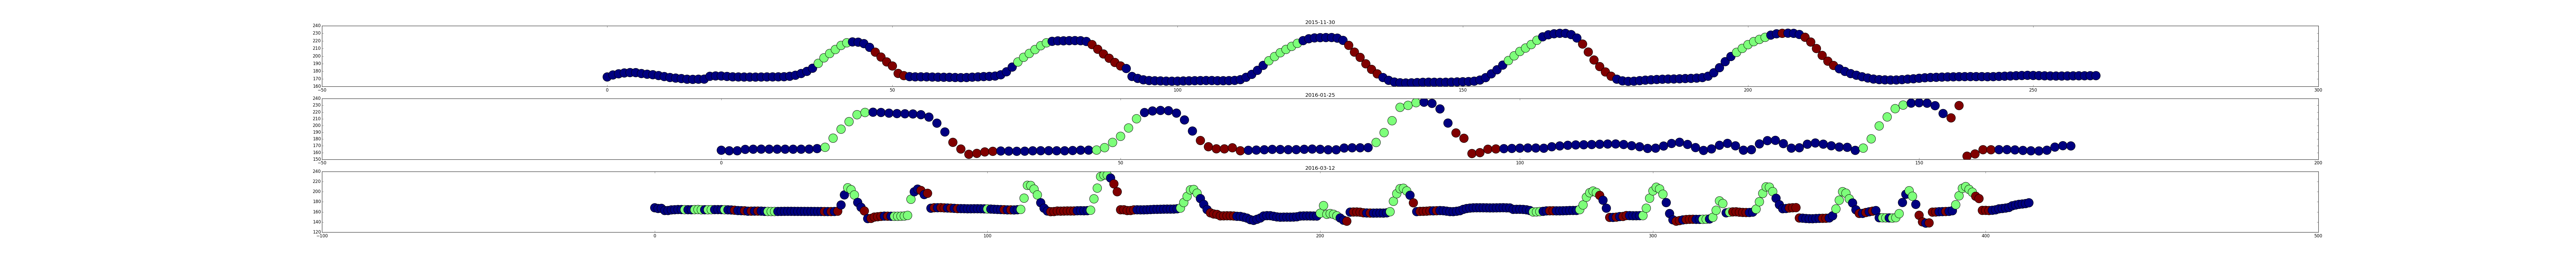

In [21]:
Image(filename='data/merged/look_left_test-plots.png')


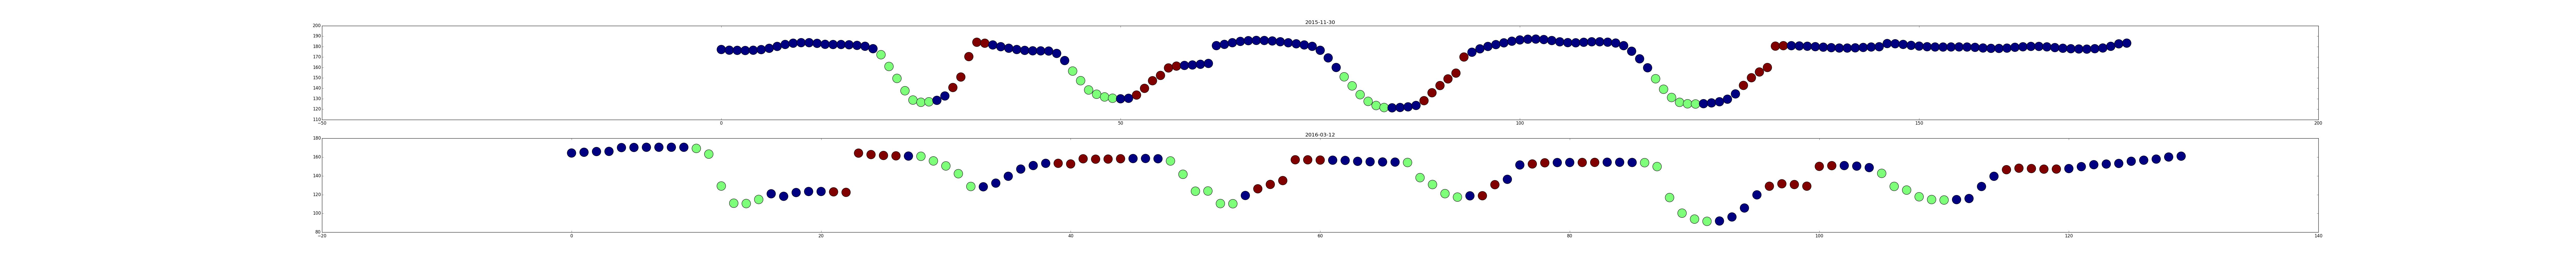

In [22]:
Image(filename='data/merged/look_right_test-plots.png')


# PART 2: Feature Engineering

In [23]:
# import cluster_merge
# %load_ext autoreload

In [24]:
# from head_features import DeltaFeatureGenerator
# def apply_m_feature_engineering(df, relevant_features = []):
#     #return df
#     df_b = df.copy()
#     sub_frames = []
#     # these are all "historic" systems
#     ignore_columns = [c for c in df_b.columns.tolist() if c not in relevant_features]
#     sub_frames.append(DeltaFeatureGenerator().generate_features(
#             df, suffix='_6_steps', step=6,relevant_features=relevant_features, # eignore_columns,
#             ))

#     sub_frames.append(DeltaFeatureGenerator().generate_features(
#             df, suffix='_1_steps', step=1, relevant_features=relevant_features,
#             #ignore_columns=ignore_columns,
#             ))
#     df_new = pd.concat(sub_frames, axis=1)
#     df_new['pos_delta_x'] = df_new['noseX_1_steps'] > 0 
#     active_features = df_new.columns.values.tolist()
#     for c in df.columns.values.tolist():
#         if not c in df_new.columns.values.tolist():
#             df_new[c] = df[c]
#     return df_new, active_features



In [25]:
# window_size = 3
# df_left, new_active_features = cluster_merge.generate_training_set(
#     'data/look_left', 
#     k = 3,
#     verbose=False,
#     window_size=window_size,
#     feature_generator = apply_m_feature_engineering,
#     relevant_features=config['relevant_features']
#     )

# df_right, new_active_features = cluster_merge.generate_training_set(
#     'data/look_right', 
#     k = 3,
#     verbose=False,
#     window_size=window_size,
#     feature_generator = apply_m_feature_engineering,
#     relevant_features=config['relevant_features']
#     )

# df_straight, new_active_features = cluster_merge.generate_training_set(
#     'data/look_straight', 
#     k = 1,
#     verbose=False,
#     window_size=window_size,
#     feature_generator = apply_m_feature_engineering,
#     relevant_features=config['relevant_features']
#     )
# df_right['class'] = df_right['class'].apply(lambda x: x + 2 if x > 0 else 0)
# df_trains = pd.concat([df_left, df_right, df_straight]) 

In [26]:
plt.figure(figsize=(50,3))
plt.scatter(xrange(len(df_trains)), df_trains['noseX'], c=df_trains['class'])


NameError: name 'df_trains' is not defined

In [31]:

pca = PCA(n_components=2)
X = pca.fit_transform(df_trains[new_active_features])
plt.scatter(X[:,0],X[:,1], c=df_trains['class'])
plt.title('Training Data with PCA(n_components = 2)')

plt.legend()
from sklearn.lda import LDA
lda = LDA(n_components=2)
X = lda.fit_transform(df_trains[new_active_features], df_trains['class'])
plt.figure()

plt.scatter(X[:,0],X[:,1], c=df_trains['class'])
plt.title("Training Data with FDA(n_components = 2)")

y_pred = lda.predict(df_trains[new_active_features])
print sum(y_pred == df_trains['class']) / float(len(df))

NameError: name 'df_trains' is not defined

In [ ]:
df_trains[['pos_delta_x_1', 'pos_delta_x_0']]